Implementation of a quantum algorithm designed to check system specification consistency, developed by Mohammed Zidan, Ahmed M. Eisa, Montasir Qasymeh, and Mahmoud A. Ismail Shoman. [ [1] ]

Circuit construction related code and analysis written by: Kate Erlikh

[1]: https://ieeexplore-ieee-org.proxy.library.carleton.ca/document/10485497 "A Quantum Algorithm for System Specifications Verification"

In [105]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from math import sqrt
import nbimporter
%matplotlib inline

Table 1. Truth table example for a consistent system with 3 variables and 2 function oracles (F1 = !X0 X2, F2 = !X0 !X1)
| X0 | X1 | X2 | F1  | F2  | Bool |
|----|----|----|----|----|----|
|  0 |  0 |  0 |  0  |  1  | False |
|  0 |  0 |  1 |  1  |  1  | True |
|  0 |  1 |  0 |  0  |  0  | False |
|  0 |  1 |  1 |  1  |  0  | False |
|  1 |  0 |  0 |  0  |  0  | False |
|  1 |  0 |  1 |  0  |  0  | False |
|  1 |  1 |  0 |  0  |  0  | False |
|  1 |  1 |  1 |  0  |  0  | False |

Table 2. Truth table example for an inconsistent system with 3 variables and 2 function oracles (F1 = X0 !X2, F2 = !X0 !X1)
| X0 | X1 | X2 | F1  | F2  | Bool |
|----|----|----|----|----|----|
|  0 |  0 |  0 |  0  |  1  | False |
|  0 |  0 |  1 |  0  |  1  | False |
|  0 |  1 |  0 |  0  |  0  | False |
|  0 |  1 |  1 |  0  |  0  | False |
|  1 |  0 |  0 |  1  |  0  | False |
|  1 |  0 |  1 |  0  |  0  | False |
|  1 |  1 |  0 |  1  |  0  | False |
|  1 |  1 |  1 |  0  |  0  | False |


In [ ]:
#Table 1 representation
consistent_system = {
    "terms" : ["0x1", "00x"], #x0 = 0, x1 = *, x2 = 1
    "var_count" : 3,
    "function_count" : 2
}

#Table 2 representation
inconsistent_system = {
    "terms" : ["1x0", "00x"],
    "var_count" : 3,
    "function_count" : 2
}

In [107]:
def init__original_circuit(var_count: int, function_count: int) -> QuantumCircuit:
    """
    Function: init_original_circuit
    Params: var_count(number of variables in system), function_count(number of functions/oracles in system)
    Return: QuantumCircuit - Circuit constructed based on parameters provided

    This function initializes the original circuit with all the registers, and sets the unknown qubits X0,X1,..Xn in a state of superposition
    """
    qc_original = QuantumCircuit()

    qc_original.add_register(QuantumRegister(var_count, name="X")) #Creates register with number of qubits n defined in system
    qc_original.h(qc_original.qregs[0]) #Adds Hadamard gates to add qubits in register X

    for i in range(function_count): #Loop that creates a register for every function oracle
        reg_name = f"F{i+1}"
        qc_original.add_register(QuantumRegister(1, name=reg_name))

    #Auxillary qubits
    qc_original.add_register(QuantumRegister(1, name="aux")) 
    qc_original.add_register(QuantumRegister(1, name="a1")) 
    qc_original.add_register(QuantumRegister(1, name="a2"))
 
    #qc_original.draw("mpl")

    return qc_original

In [108]:
def apply_oracles(qc_original: QuantumCircuit, terms: list, function_count: int) -> QuantumCircuit:
    """
    Function: apply_oracles
    Parameters: qc_original(original circuit), terms(terms of the functions from truth table), function_count(number of terms to create)
    Return: Circuit with oracles on the original circuit

    Based on the terms provided, this function will create oracles and apply them to the circuit accordingly.
    """
    for i in range(function_count):
        reg_c = qc_original.qregs[0]
        reg_t = qc_original.qregs[i+1]
        term = terms[i]

        c1, c2, c_p1, c_p2 = None, None, None, None #Control 1 value, control 2 value, control 1 position, control 2 position

        for j in range(len(term)): #Determines position and value of the controls
            if term[j] == '0' or term[j] == '1':
                if c1 == None:
                    c1 = int(term[j])
                    c_p1 = j
                else:
                    c2 = int(term[j])
                    c_p2 = j
        print(f"c1: {c1}, c2: {c2}")
        qc_original.ccx(reg_c[c_p1], reg_c[c_p2], reg_t[0], ctrl_state=f"{c2}{c1}") #Creates oracle based on the term control values, applies it to the function as a target

    #qc_original.draw("mpl") 

    return qc_original
        

In [109]:
def apply_aux_hadamard(qc_original: QuantumCircuit, function_count: int) -> QuantumCircuit:
    """
    Function: apply_aux_hadamard
    Parameters: qc_original(original circuit), function_count(number of oracle functions)
    Return: Original circuit with newly added gates

    Applies the multi-controled X gate and control hadamard gate
    """
    reg_control = [] #List of registers to apply the multi-controlled X gate to

    for i in range(function_count): #Loop to add registers to list
        reg_control.append(qc_original.qregs[1+i]) 

    qc_original.mcx(reg_control, qc_original.qregs[function_count+1][0]) #Applies multi-controlled X gate to given registers as control
    qc_original.ch(qc_original.qregs[function_count+1][0], qc_original.qregs[function_count+2][0]) #Applies controlled Hadamard gate to aux and a1

    #qc_original.draw("mpl")

    return qc_original

In [110]:
def mirror_circuit(qc_original: QuantumCircuit) -> QuantumCircuit:
    """
    Function: mirror_circuit
    Parameters: qc_original(original circuit), function_count(number of oracle function registers), var_count(number of variables in X register)
    Return: Final circuit with original and mirrored circuit

    Creates circuit with original copy and mirrored copy. Register names of original circuit are the same, anything mirrored has the '_m' lable.
    """

    qc_mirror_temp = qc_original.copy()
    qc_mirror_temp = qc_mirror_temp.reverse_bits() #Temprary mirrored circuit

    qc_mirror = QuantumCircuit() #Actual mirrored circuit

    """
    To copy the mirrored circuit to the final circuit, the register names must differ. 
    To achieve this, the contents of the temprary mirrored circuit was added to the mirrored circuit with renamed registers. 
    """
    qubit_mapping = {} #mapping old qubit to new qubit to help with new register name transition
    for reg in qc_mirror_temp.qregs:
        new_reg = QuantumRegister(reg.size, name=f"{reg.name}ₘ") #new register with new name
        qc_mirror.add_register(new_reg)

        for old_qubit, new_qubit in zip(reg, new_reg): #for loop for mapping qubits
            qubit_mapping[old_qubit] = new_qubit
    
    for gate in qc_mirror_temp.data: #add gates to newply mapped qubits
        operation = gate.operation
        qubits = gate.qubits
        clbits = gate.clbits
        new_qubits = [qubit_mapping[q] for q in qubits]
        qc_mirror.append(operation, new_qubits, clbits)
    
    
    qc_final = QuantumCircuit() #Final circuit with mirrored and original cirucit
    
    #Copies over the data from the original and mirrored circuits into the final circuit
    for reg in qc_original.qregs:
        qc_final.add_register(QuantumRegister(reg.size, name=reg.name))

    for gate in qc_original.data:
        operation = gate.operation
        qubits = gate.qubits
        clbits = gate.clbits
        qc_final.append(operation, qubits)

    for reg in qc_mirror.qregs:
        qc_final.add_register(QuantumRegister(reg.size, name=reg.name))

    for gate in qc_mirror.data:
        operation = gate.operation
        qubits = gate.qubits
        clbits = gate.clbits
        qc_final.append(operation, qubits)

    #qc_final.draw("mpl")

    return qc_final

In [111]:
def measure_aux(qc_final: QuantumCircuit, function_count: int) -> QuantumCircuit:
    """
    Function: measure_aux
    Parameters: qc_original(original circuit), function_count(number of oracle function registers), var_count(number of variables in X register)
    Return: Final circuit with measurments on a qubits

    Provides a classical register for the measurment of the a qubits. Also applies the Mz measurment gate as given in the article [1].
    """
    #Positions of the a qubits for the given circuit
    a11 = qc_final.qregs[function_count + 1 + 1][0] #function count + var reg + increment
    a21 = qc_final.qregs[function_count + 1 + 2][0]
    a12 = qc_final.qregs[function_count + 1 + 3][0]
    a22 = qc_final.qregs[function_count + 1 + 4][0]
    
    #Applies control X gate to the given a qubits
    qc_final.cx(a11, a21)
    qc_final.cx(a22, a12)

    qc_final.barrier()

    a_measure = ClassicalRegister(4, name="measure_a") #Creation of the classical register
    qc_final.add_register(a_measure) 
    qc_final.measure([a11, a21, a12, a22], a_measure) #Add measurments for all of the a qubits

    #qc_final.draw("mpl")

    return qc_final

In [112]:
def check_consistency(sim_prob: list) -> bool:
    """
    Function: check_consistency
    Parameters: sim_prob(A list of length 2 with the required probabilites P0011, P1100)
    Return: bool value of whether system is consistent

    Measurment of the probabilities of the system to determine of the system specification configurations are compliant.
    """
    C = sqrt(2*(sim_prob[0]+sim_prob[1])) #Equation as provided in the study [1]
    if C>0:
        print(f"The system is consistent. C={C}")
        return True
    else:
        print(f"The system is inconsistent. C={C}")
        return False

In [113]:
def construct_circuit(terms: list, var_count: int, func_count: int) -> QuantumCircuit:
    circuit = init__original_circuit(var_count, func_count)
    apply_oracles(circuit, terms, func_count)
    apply_aux_hadamard(circuit, func_count)
    final_circuit =  mirror_circuit(circuit)
    measure_aux(final_circuit, func_count)

    return final_circuit

c1: 1, c2: 0
c1: 0, c2: 0


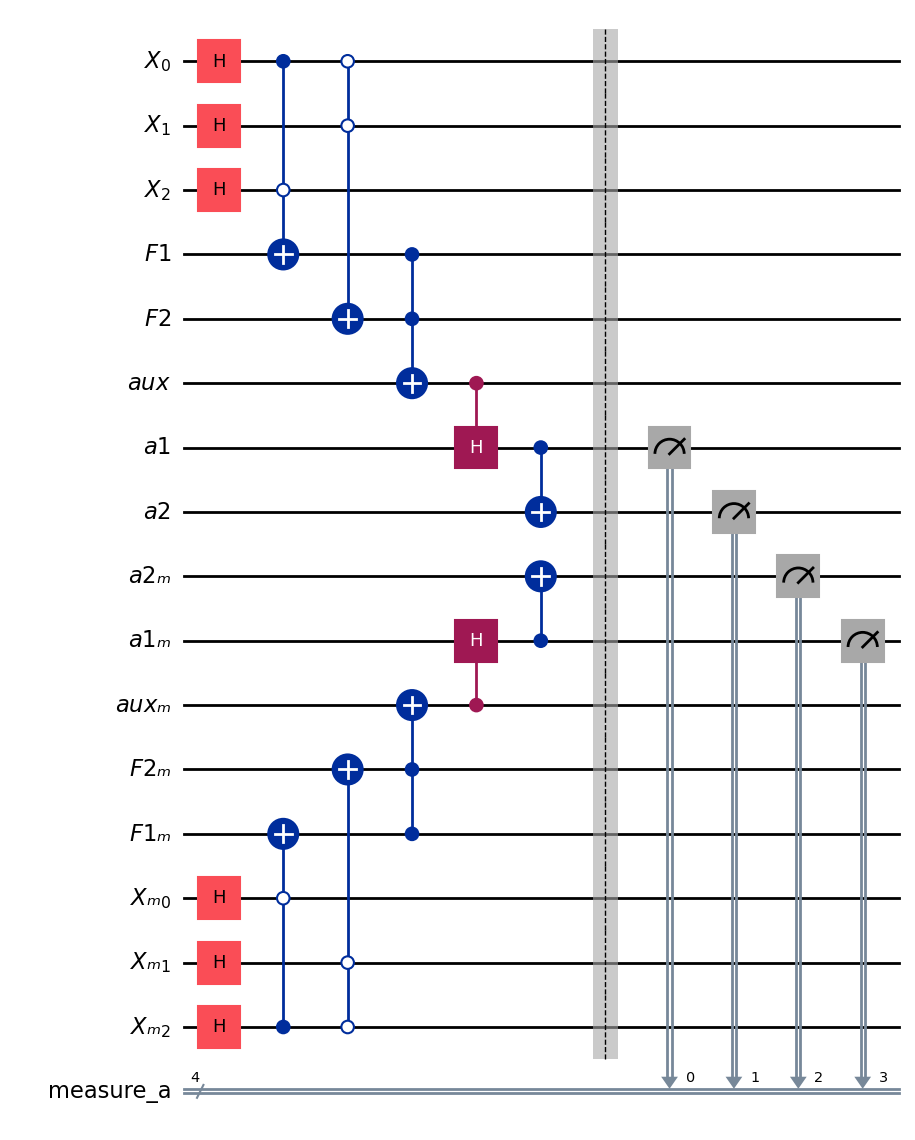

In [114]:
circuit = construct_circuit(consistent_system.get("terms"), consistent_system.get("var_count"),consistent_system.get("function_count"))
circuit.draw("mpl");

References

[1] M. Zidan, A. M. Eisa, M. Qasymeh, and M. A. I. Shoman, “A quantum
algorithm for system specifications verification,” IEEE Internet of Things
Journal, vol. 11, no. 14, pp. 24 775–24 794, 2024.
```